In [1]:
# Dependencies for test visualisations
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Bokeh dependencies
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure

from bokeh.core.enums import MarkerType
from bokeh.io import curdoc, show
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Plot, Scatter, MultiChoice, Select
from bokeh.transform import factor_cmap
from bokeh.models import HoverTool
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

from bokeh.palettes import Category10 

output_notebook()

Loading BokehJS ...

In [2]:
# Load file that we want to visualize
CSVFILE = 'output/2D_magnetosphere.csv'
df = pd.read_csv(CSVFILE)
df.head()

,fileid,cellid,s0_min,s0_max,s0_mean,s0_median,s0_var,s0_skew,s0_kurt,s0_zeros,...,s24_kurt,s24_zeros,mean,zeros,partials,gap,spatial_x,spatial_y,spatial_z,pngfile
0,4000,1,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-599850000.0,0.0,-359850000.0,f0004000c00001.png
1,4000,51,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-584850000.0,0.0,-359850000.0,f0004000c00051.png
2,4000,101,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-569850000.0,0.0,-359850000.0,f0004000c00101.png
3,4000,151,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-554850000.0,0.0,-359850000.0,f0004000c00151.png
4,4000,201,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-539850000.0,0.0,-359850000.0,f0004000c00201.png


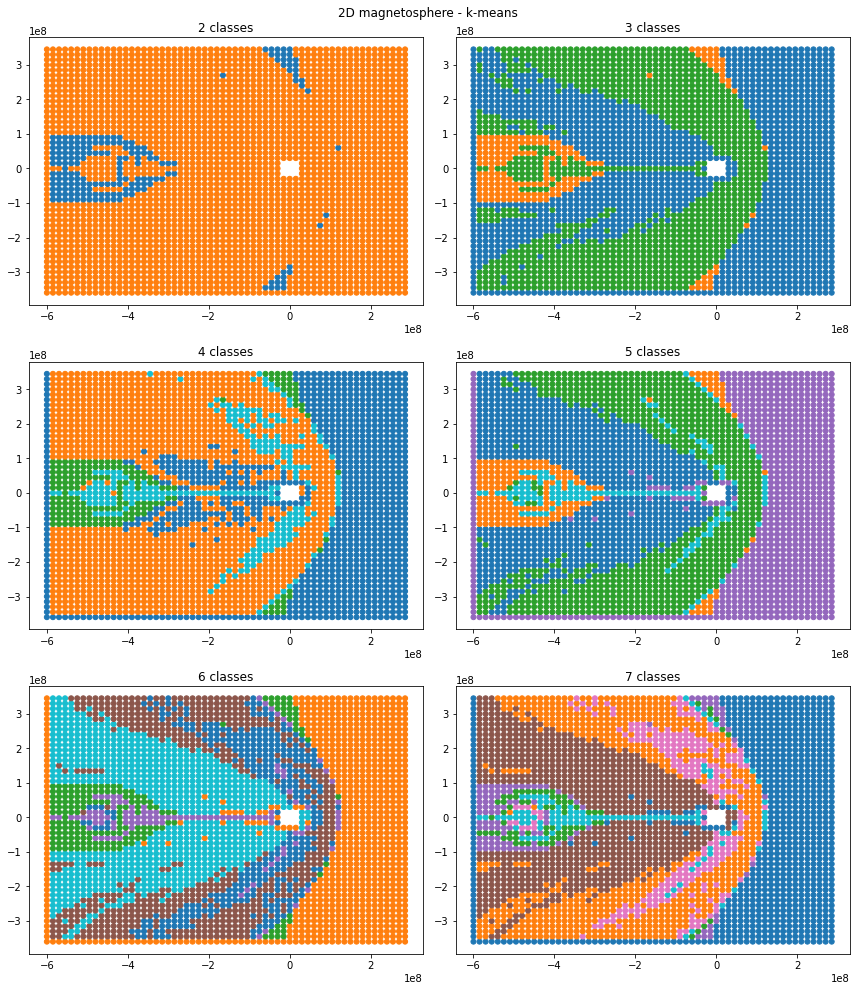

In [3]:
# Test visualization with matplotlib to understand what we'd want to draw

cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

fig, ax = plt.subplots(3, 2, figsize=(12, 14))
ax = ax.flatten()

for i, n_classes in enumerate(range(2, 8)):
    cols = ['gap', 'mean', 'zeros', 'partials']
    kmeans = KMeans(n_clusters=n_classes).fit(df[cols].values)

    kmeans_df = pd.DataFrame(df[['fileid', 'cellid', 'spatial_x', 'spatial_y', 'spatial_z', 'pngfile']])
    kmeans_df.insert(2, 'class', kmeans.labels_)

    _ = ax[i].scatter(kmeans_df['spatial_x'], kmeans_df['spatial_z'], c=kmeans_df['class'], s=25, cmap=cmap, norm=norm)
    ax[i].set_title(f'{n_classes} classes')

plt.suptitle('2D magnetosphere - k-means')
plt.tight_layout()
plt.show()


In [4]:
# Function that can prepare the data from CSV to DataFrame

def csv_data_to_bokeh(csv_file, n_classes, cols, pca_transform=False, pca_variance=0.9):
    df = pd.read_csv(csv_file)
    if pca_transform:
        X = df.drop(["fileid", "cellid", "spatial_x", "spatial_y", "spatial_z", "pngfile"], axis=1)
        X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=pca_variance)
        pca_res = pca.fit_transform(X)
        kmeans = KMeans(n_clusters=n_classes).fit(pca_res)
    else:
        kmeans = KMeans(n_clusters=n_classes).fit(df[cols].values)
    kmeans_df = pd.DataFrame(df[['fileid', 'cellid', 'spatial_x', 'spatial_y', 'spatial_z', 'pngfile']])
    kmeans_df.insert(2, 'class', kmeans.labels_)

    # Transform classes to strings as Bokeh wants them as strings
    kmeans_df['class'] = ['class_'+str(i) for i in kmeans_df['class']]

    return(kmeans_df)

csv_file = 'output/2D_magnetosphere.csv'
n_classes = 6
cols = ['gap', 'mean', 'zeros', 'partials']
kmeans_df = csv_data_to_bokeh(csv_file, n_classes, cols)
kmeans_df

,fileid,cellid,class,spatial_x,spatial_y,spatial_z,pngfile
0,4000,1,class_2,-599850000.0,0.0,-359850000.0,f0004000c00001.png
1,4000,51,class_2,-584850000.0,0.0,-359850000.0,f0004000c00051.png
2,4000,101,class_2,-569850000.0,0.0,-359850000.0,f0004000c00101.png
3,4000,151,class_2,-554850000.0,0.0,-359850000.0,f0004000c00151.png
4,4000,201,class_2,-539850000.0,0.0,-359850000.0,f0004000c00201.png
...,...,...,...,...,...,...,...
2866,4000,7052751,class_2,225150000.0,0.0,345150000.0,f0004000c7052751.png
2867,4000,7052801,class_2,240150000.0,0.0,345150000.0,f0004000c7052801.png
2868,4000,7052851,class_2,255150000.0,0.0,345150000.0,f0004000c7052851.png
2869,4000,7052901,class_2,270150000.0,0.0,345150000.0,f0004000c7052901.png


In [8]:
# Helpful guide to make interactive Jupyter notebooks:
# https://stackoverflow.com/questions/53217654/how-to-get-interactive-bokeh-in-jupyter-notebook


# Visual options for chart
width = 840
height = 600
circle_size = 12


COLS_OPTIONS = ['gap', 'mean', 'zeros', 'partials']


# Data variables etc
csv_file = 'output/2D_magnetosphere.csv'
n_classes = 6
cols = ['gap', 'mean', 'zeros', 'partials']
kmeans_df = csv_data_to_bokeh(csv_file, n_classes, cols)
source = ColumnDataSource(data=kmeans_df)


# Create color map for classes
index_cmap = factor_cmap('class', palette=list(Category10[10]),factors=sorted(kmeans_df['class'].unique()))

# Create hover tooltip for single cell
hover = HoverTool(
    tooltips="""
    <div>
        <img
            src="output/2D_magnetosphere/images/smallblob/@pngfile" alt="@cellid"
            style="margin: 0px 0px 10px 0px; border: 1px solid #000; width: 100px; height: 100px;"
        />
        <div style="font-size: 15px; font-weight: bold;">@cellid</div>
        <div style="font-size: 13px; color: #696;">($x, $y)</div>
    </div>
    """
)

# Initialize our plot
p = figure(
    title = "2D Magnetosphere", 
    width=width, 
    height=height,
    tools=[hover]
)

# Render the data to scatter plot
p.circle(
    'spatial_x', # X coordinate
    'spatial_z', # Y coordinate
    source=source,
    fill_alpha=1, 
    size=circle_size, 
    fill_color=index_cmap, 
    line_width=0
)

# Add sliders to the plot

def update_n_classes(attrname, old, new):
    n_classes = new
    kmeans_df = csv_data_to_bokeh(csv_file, n_classes, cols)
    source.data = kmeans_df

def update_cols(attrname, old, new):
    if len(new) > 0:
        cols = new
        kmeans_df = csv_data_to_bokeh(csv_file, n_classes, cols)
        source.data = kmeans_df
    else:
        print("Value change ignored: at least one column needs to be selected!")

def update_pca_transform(attrname, old, new):
    pca_transform = True if new == "ON" else False 
    kmeans_df = csv_data_to_bokeh(csv_file, n_classes, cols, pca_transform=pca_transform)
    source.data = kmeans_df

def update_pca_variance(attrname, old, new):
    pca_variance = new
    kmeans_df = csv_data_to_bokeh(csv_file, n_classes, cols, pca_transform=True, pca_variance=pca_variance)
    source.data = kmeans_df

class_slider = Slider(start=1, end=10, value=5, step=1, title="Number of classes")
multi_choice = MultiChoice(value=cols, options=COLS_OPTIONS, title="Selected columns")
select = Select(title="PCA transform", value="pca_transform", options = ["OFF", "ON"])
pca_slider = Slider(start=0.0, end=1.0, value=0.9, step=0.05, title="Explained variance by PCs")

class_slider.on_change('value', update_n_classes)
multi_choice.on_change('value', update_cols)
select.on_change('value', update_pca_transform)
pca_slider.on_change('value', update_pca_variance)

layout = row(p, column(class_slider, multi_choice, select, pca_slider))


def modify_doc(doc):
    doc.add_root(row(layout, width=800))

handler = FunctionHandler(modify_doc)

app = Application(handler)
show(app)